## SQL IPYNB

# This notebook is a SQL notebook that can be run in Jupyter Notebook or JupyterLab.
# It will be used to queury the columns for our project.

In [ ]:
# Install required libraries (only once)
# !pip install wbdata pandas

import wbdata
import pandas as pd
import sqlite3

# 1. Set indicators
indicators = {
    'SP.DYN.LE00.IN': 'life_expectancy',
    'SH.DYN.MORT': 'under5_mortality_rate',
    'SP.ADO.TFRT': 'adolescent_fertility_rate'
}

# 2. Fetch data (NO date filter)
df = wbdata.get_dataframe(indicators)

# 3. Reset index
df = df.reset_index()

# 4. Drop rows with missing values
df = df.dropna()

# 5. Load into SQLite in-memory database
conn = sqlite3.connect(':memory:')
df.to_sql('population_data', conn, index=False, if_exists='replace')

# 6. Create cleaned table
conn.execute("""
CREATE TABLE cleaned_population_data AS
SELECT
    country,
    date,
    life_expectancy,
    under5_mortality_rate,
    adolescent_fertility_rate
FROM
    population_data
WHERE
    life_expectancy IS NOT NULL
    AND under5_mortality_rate IS NOT NULL
    AND adolescent_fertility_rate IS NOT NULL
""")
conn.commit()

# 7. Descriptive stats
stats_query = """
SELECT
    AVG(life_expectancy) AS avg_life_expectancy,
    MIN(life_expectancy) AS min_life_expectancy,
    MAX(life_expectancy) AS max_life_expectancy,
    AVG(under5_mortality_rate) AS avg_under5_mortality,
    MIN(under5_mortality_rate) AS min_under5_mortality,
    MAX(under5_mortality_rate) AS max_under5_mortality,
    AVG(adolescent_fertility_rate) AS avg_adolescent_fertility,
    MIN(adolescent_fertility_rate) AS min_adolescent_fertility,
    MAX(adolescent_fertility_rate) AS max_adolescent_fertility
FROM
    cleaned_population_data
"""
stats_result = pd.read_sql_query(stats_query, conn)
print(stats_result)

# 8. Group by country
grouped_query = """
SELECT
    country,
    AVG(life_expectancy) AS avg_life_expectancy,
    AVG(under5_mortality_rate) AS avg_under5_mortality_rate,
    AVG(adolescent_fertility_rate) AS avg_adolescent_fertility_rate
FROM
    cleaned_population_data
GROUP BY
    country
ORDER BY
    avg_life_expectancy DESC
"""
grouped_result = pd.read_sql_query(grouped_query, conn)
print(grouped_result.head())


# Query the cleaned table into a DataFrame
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_population_data", conn)

# Now cleaned_df is a normal DataFrame you can manipulate 
print(cleaned_df.head())

# Save cleaned_df as a CSV file
cleaned_df.to_csv('clean_data.csv', index=False)

# Confirm the file was saved
print("clean_data.csv has been saved.")



   avg_life_expectancy  min_life_expectancy  max_life_expectancy  \
0            65.252508               10.989               86.372   

   avg_under5_mortality  min_under5_mortality  max_under5_mortality  \
0             71.114946                   1.4                 767.4   

   avg_adolescent_fertility  min_adolescent_fertility  \
0                 72.515224                     0.512   

   max_adolescent_fertility  
0                   229.604  
                     country  avg_life_expectancy  avg_under5_mortality_rate  \
0                     Monaco            82.924282                   5.166667   
1                    Andorra            82.030308                   7.423077   
2                 San Marino            81.448641                   6.107692   
3                  Euro area            79.545286                   5.312769   
4  Post-demographic dividend            78.542056                   6.698336   

   avg_adolescent_fertility_rate  
0                      14.336

In [ ]:
import pandas as pd

# Read the clean_data.csv file into a DataFrame
cleaned_df = pd.read_csv('clean_data.csv')

# Display the first few rows to confirm
print(cleaned_df.head())

# Convert 'date' to integer
cleaned_df['date'] = cleaned_df['date'].astype(int)

# Check
print(cleaned_df.dtypes)

country                       object
date                           int32
life_expectancy              float64
under5_mortality_rate        float64
adolescent_fertility_rate    float64
dtype: object


In [3]:
# Define the 7 major regions you want
regions_of_interest = [
    'East Asia & Pacific',
    'Europe & Central Asia',
    'Latin America & Caribbean',
    'Middle East & North Africa',
    'North America',
    'South Asia',
    'Sub-Saharan Africa'
]

# Filter cleaned_df
region_df = cleaned_df[cleaned_df['country'].isin(regions_of_interest)]

# Check what you get
print(region_df['country'].unique())
region_df.head()

# Save region_df as a CSV file
region_df.to_csv('region_data.csv', index=False)

# Confirm the file was saved
print("region_data.csv has been saved.")

['East Asia & Pacific' 'Europe & Central Asia' 'Latin America & Caribbean'
 'Middle East & North Africa' 'North America' 'South Asia'
 'Sub-Saharan Africa']
region_data.csv has been saved.


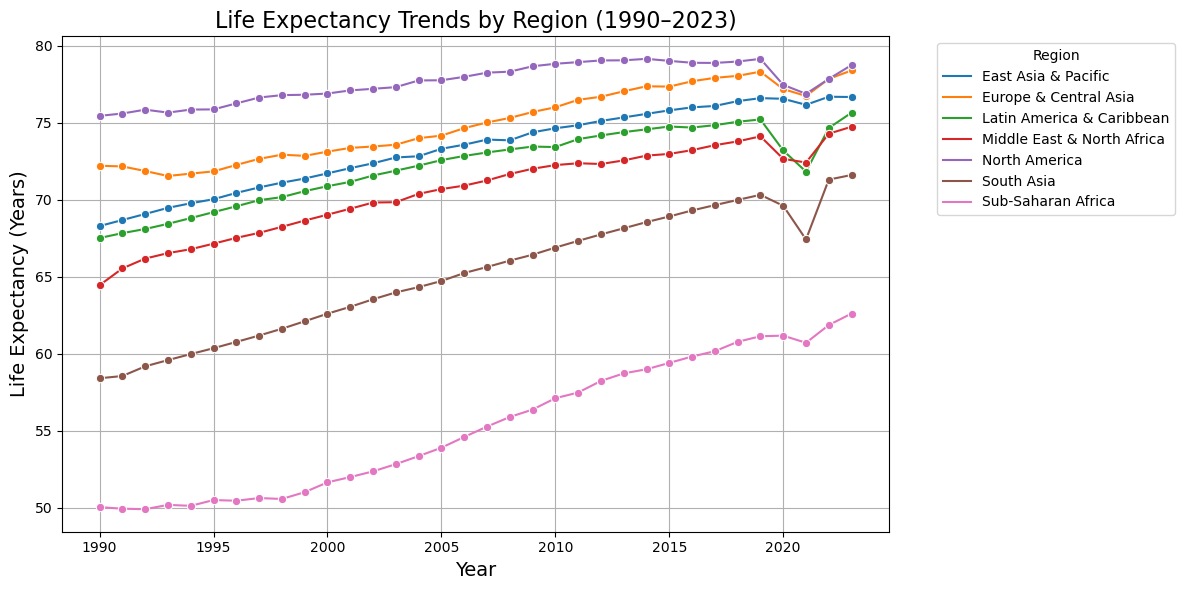

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Read the CSV file into a DataFrame
region_df = pd.read_csv('region_data.csv')

# Display the first few rows to confirm
print(region_df.head())

# Plot Life Expectancy over Time for 7 regions
plt.figure(figsize=(12,6))
sns.lineplot(
    data=region_df,
    x='date',
    y='life_expectancy',
    hue='country',
    marker='o'
)

plt.title('Life Expectancy Trends by Region (1990–2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Life Expectancy (Years)', fontsize=14)
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Life expectancy increased steadily across all global regions from 1990 to 2023, with North America consistently maintaining the highest values. Sub-Saharan Africa started with the lowest life expectancy but showed steady improvements over time. A slight decline around 2020 is noticeable across several regions, likely reflecting the impact of the COVID-19 pandemic. Regions such as East Asia & Pacific and Europe & Central Asia made notable progress, narrowing the life expectancy gap with North America by the end of the period.

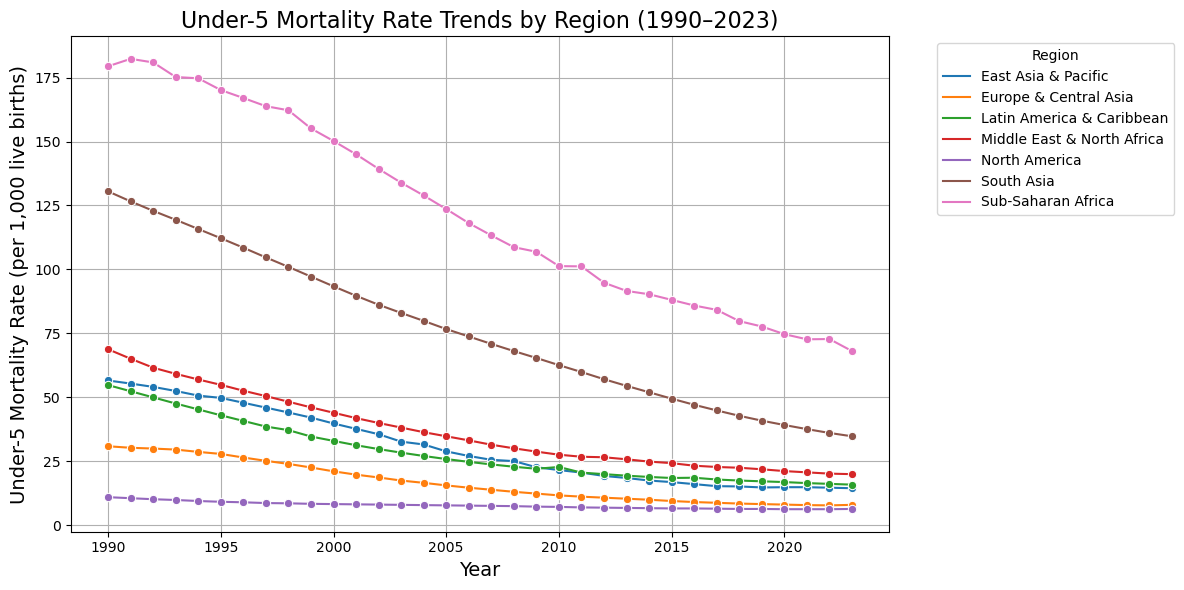

In [8]:
# Plot Under-5 Mortality over Time for 7 regions
plt.figure(figsize=(12,6))
sns.lineplot(
    data=region_df,
    x='date',
    y='under5_mortality_rate',
    hue='country',
    marker='o'
)

plt.title('Under-5 Mortality Rate Trends by Region (1990–2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Under-5 Mortality Rate (per 1,000 live births)', fontsize=14)
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Under-5 mortality rates declined dramatically across all regions between 1990 and 2023. Sub-Saharan Africa, although starting with the highest child mortality rates, achieved significant improvements over this period. South Asia also experienced a major reduction in under-5 mortality rates. North America and Europe & Central Asia maintained very low child mortality rates throughout, highlighting their strong healthcare systems. Globally, this figure reflects tremendous success in improving child health outcomes over the past three decades.

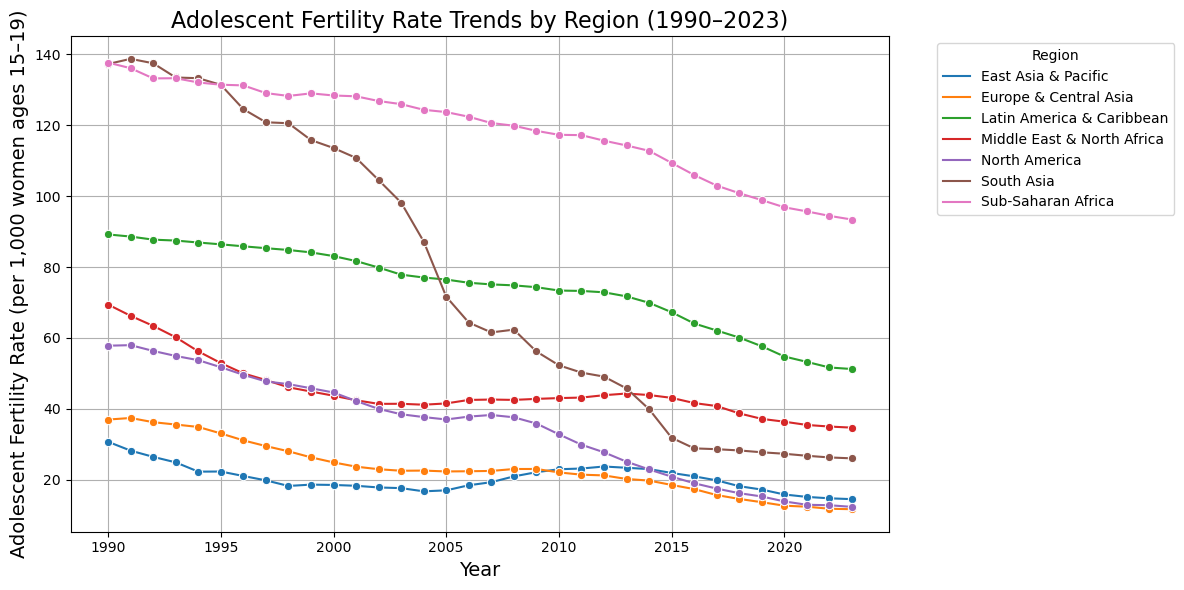

In [9]:
# Plot Adolescent Fertility over Time for 7 regions
plt.figure(figsize=(12,6))
sns.lineplot(
    data=region_df,
    x='date',
    y='adolescent_fertility_rate',
    hue='country',
    marker='o'
)

plt.title('Adolescent Fertility Rate Trends by Region (1990–2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Adolescent Fertility Rate (per 1,000 women ages 15–19)', fontsize=14)
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Adolescent fertility rates (births among women aged 15–19) fell substantially across all regions from 1990 to 2023. South Asia, which initially had one of the highest rates, demonstrated a sharp and sustained decrease over the period. Sub-Saharan Africa also made progress but still maintains higher adolescent fertility compared to other regions. North America and Europe & Central Asia consistently exhibited lower adolescent fertility rates. Overall, the trends reflect global improvements in education, healthcare access, and reproductive health services for young women.

In [10]:
# Filter only for 1990 and 2023
df_1990 = region_df[region_df['date'] == 1990]
df_2023 = region_df[region_df['date'] == 2023]

In [11]:
# Merge 1990 and 2023 data by region
region_change = pd.merge(
    df_1990,
    df_2023,
    on='country',
    suffixes=('_1990', '_2023')
)

# Check it
region_change.head()


,country,date_1990,life_expectancy_1990,under5_mortality_rate_1990,adolescent_fertility_rate_1990,date_2023,life_expectancy_2023,under5_mortality_rate_2023,adolescent_fertility_rate_2023
0,East Asia & Pacific,1990,68.282548,56.6,30.734116,2023,76.659477,14.5,14.565804
1,Europe & Central Asia,1990,72.194387,30.9,37.003769,2023,78.385084,8.0,11.730673
2,Latin America & Caribbean,1990,67.506605,54.8,89.188980,2023,75.643533,15.9,51.245503
3,Middle East & North Africa,1990,64.442541,68.8,69.422435,2023,74.728942,20.0,34.723922
4,North America,1990,75.436199,11.0,57.824486,2023,78.734684,6.4,12.382407


In [12]:
# Calculate % change for each indicator
region_change['life_expectancy_pct_change'] = (
    (region_change['life_expectancy_2023'] - region_change['life_expectancy_1990']) /
    region_change['life_expectancy_1990']
) * 100

region_change['under5_mortality_pct_change'] = (
    (region_change['under5_mortality_rate_2023'] - region_change['under5_mortality_rate_1990']) /
    region_change['under5_mortality_rate_1990']
) * 100

region_change['adolescent_fertility_pct_change'] = (
    (region_change['adolescent_fertility_rate_2023'] - region_change['adolescent_fertility_rate_1990']) /
    region_change['adolescent_fertility_rate_1990']
) * 100

# View final table
region_change[['country', 'life_expectancy_pct_change', 'under5_mortality_pct_change', 'adolescent_fertility_pct_change']]

,country,life_expectancy_pct_change,under5_mortality_pct_change,adolescent_fertility_pct_change
0,East Asia & Pacific,12.268037,-74.381625,-52.607050
1,Europe & Central Asia,8.575038,-74.110032,-68.298707
2,Latin America & Caribbean,12.053528,-70.985401,-42.542786
3,Middle East & North Africa,15.962128,-70.930233,-49.981699
4,North America,4.372550,-41.818182,-78.586222
5,South Asia,22.597796,-73.333333,-81.009521
6,Sub-Saharan Africa,25.115112,-62.040134,-32.148331


This table summarizes the percentage changes in life expectancy, under-5 mortality rates, and adolescent fertility rates from 1990 to 2023 across different global regions. Sub-Saharan Africa and South Asia experienced the largest improvements in life expectancy, with gains of approximately 25% and 23%, respectively. North America had the smallest life expectancy increase at just over 4%, reflecting its already high starting point in 1990. In terms of under-5 mortality, all regions made significant progress, with East Asia & Pacific, Europe & Central Asia, Middle East & North Africa, and South Asia all achieving reductions of around 70% to 74%. Although Sub-Saharan Africa saw a smaller decline of around 62%, it still made substantial strides in reducing child mortality. Regarding adolescent fertility rates, South Asia showed the most dramatic improvement with an 81% reduction, while North America also recorded a notable 78% decline. Sub-Saharan Africa reduced adolescent fertility by 32%, a meaningful improvement but smaller relative to other regions. Overall, South Asia demonstrated the most comprehensive health improvements, while Sub-Saharan Africa, despite strong progress, continues to face greater health challenges compared to other regions.

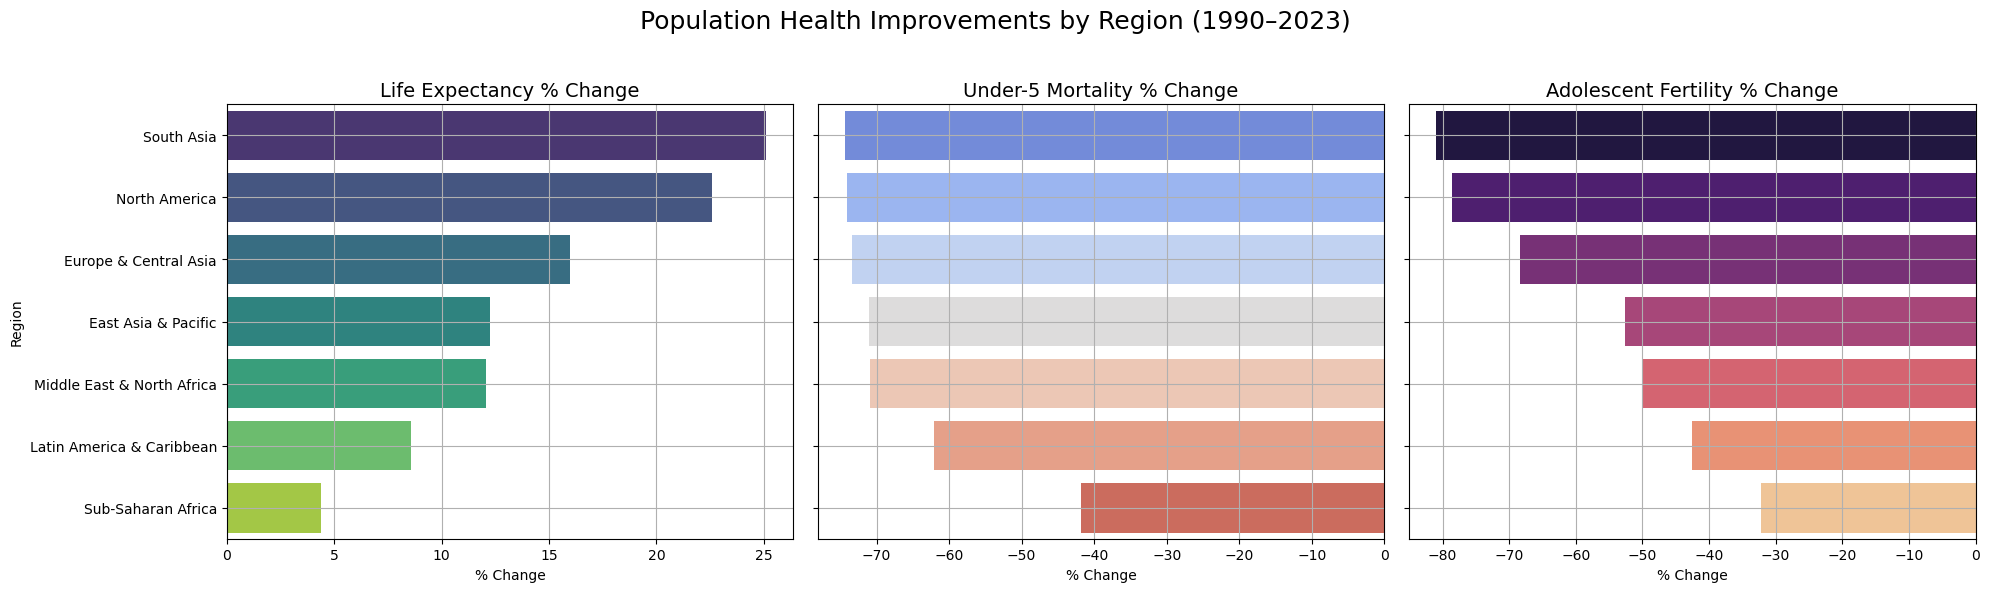

In [13]:
# Create a combined figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20,6), sharey=True)

# Plot 1: Life Expectancy % Change
sns.barplot(
    data=region_change.sort_values('life_expectancy_pct_change', ascending=False),
    x='life_expectancy_pct_change',
    y='country',
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Life Expectancy % Change', fontsize=14)
axes[0].set_xlabel('% Change')
axes[0].set_ylabel('Region')
axes[0].grid(True)

# Plot 2: Under-5 Mortality % Change
sns.barplot(
    data=region_change.sort_values('under5_mortality_pct_change', ascending=True),
    x='under5_mortality_pct_change',
    y='country',
    ax=axes[1],
    palette='coolwarm'
)
axes[1].set_title('Under-5 Mortality % Change', fontsize=14)
axes[1].set_xlabel('% Change')
axes[1].set_ylabel('')  # Don't repeat "Region"
axes[1].grid(True)

# Plot 3: Adolescent Fertility % Change
sns.barplot(
    data=region_change.sort_values('adolescent_fertility_pct_change', ascending=True),
    x='adolescent_fertility_pct_change',
    y='country',
    ax=axes[2],
    palette='magma'
)
axes[2].set_title('Adolescent Fertility % Change', fontsize=14)
axes[2].set_xlabel('% Change')
axes[2].set_ylabel('')
axes[2].grid(True)

# Main title
fig.suptitle('Population Health Improvements by Region (1990–2023)', fontsize=18)

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for main title
plt.show()

From 1990 to 2023, South Asia and Sub-Saharan Africa achieved the largest percentage increases in life expectancy and significant reductions in under-5 mortality and adolescent fertility rates. South Asia, in particular, stands out for achieving the greatest decline in adolescent fertility. North America showed relatively smaller gains, likely because it already had high health outcomes by 1990. This visualization highlights how relative improvements were greatest in regions that initially faced the most severe health challenges.

In [14]:
# Correlation between life expectancy improvements and other indicators
corr_under5 = region_change[['life_expectancy_pct_change', 'under5_mortality_pct_change']].corr().iloc[0,1]
corr_fertility = region_change[['life_expectancy_pct_change', 'adolescent_fertility_pct_change']].corr().iloc[0,1]

print(f"Correlation between Life Expectancy Change and Under-5 Mortality Change: {corr_under5:.3f}")
print(f"Correlation between Life Expectancy Change and Adolescent Fertility Change: {corr_fertility:.3f}")

Correlation between Life Expectancy Change and Under-5 Mortality Change: -0.364
Correlation between Life Expectancy Change and Adolescent Fertility Change: 0.388


There is a moderate negative correlation (r = -0.364) between life expectancy improvements and reductions in under-5 mortality rates. This suggests that regions that achieved greater declines in child mortality tended to experience larger gains in life expectancy. However, the relationship is not extremely strong, implying that while child health improvements contribute meaningfully to longer life spans, other factors also influence life expectancy trends.

A moderate positive correlation (r = 0.388) was found between improvements in life expectancy and reductions in adolescent fertility rates. This indicates that regions with larger declines in teenage pregnancy rates tended to experience greater gains in life expectancy. The association is noticeable but moderate, suggesting that reducing adolescent fertility likely plays a supporting role in broader population health improvements.

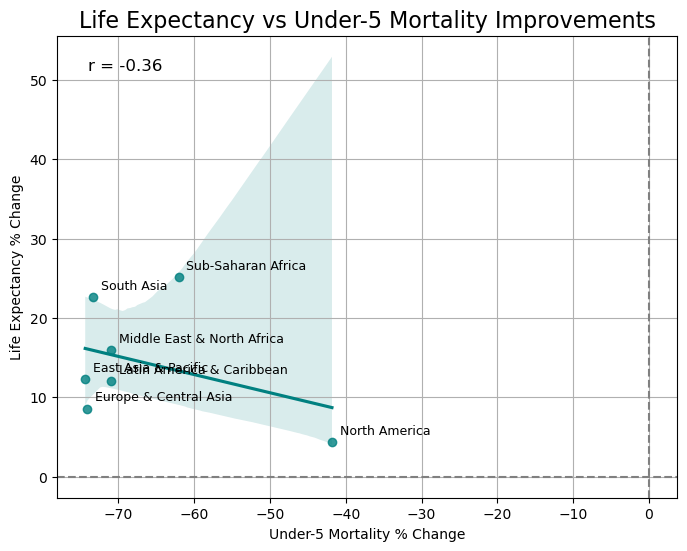

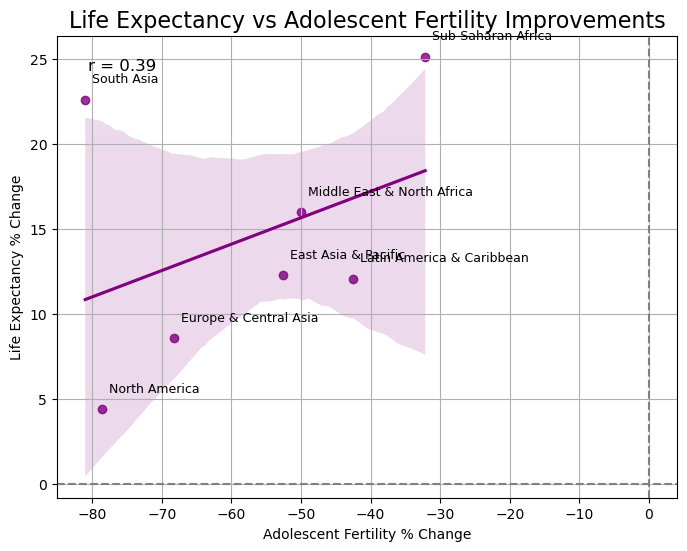

In [15]:
import scipy.stats as stats

# Calculate correlations
corr_under5, _ = stats.pearsonr(region_change['under5_mortality_pct_change'], region_change['life_expectancy_pct_change'])
corr_fertility, _ = stats.pearsonr(region_change['adolescent_fertility_pct_change'], region_change['life_expectancy_pct_change'])

# Scatterplot: Life Expectancy vs Under-5 Mortality Improvements
plt.figure(figsize=(8,6))
sns.regplot(
    data=region_change,
    x='under5_mortality_pct_change',
    y='life_expectancy_pct_change',
    scatter=True,
    color='teal',
    marker='o'
)
for i in range(region_change.shape[0]):
    plt.text(
        region_change['under5_mortality_pct_change'].iloc[i]+1,
        region_change['life_expectancy_pct_change'].iloc[i]+1,
        region_change['country'].iloc[i],
        fontsize=9
    )
plt.title('Life Expectancy vs Under-5 Mortality Improvements', fontsize=16)
plt.xlabel('Under-5 Mortality % Change')
plt.ylabel('Life Expectancy % Change')
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
# Add correlation text
plt.text(
    0.05, 0.95, f'r = {corr_under5:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)
plt.show()

# Scatterplot: Life Expectancy vs Adolescent Fertility Improvements
plt.figure(figsize=(8,6))
sns.regplot(
    data=region_change,
    x='adolescent_fertility_pct_change',
    y='life_expectancy_pct_change',
    scatter=True,
    color='purple',
    marker='o'
)
for i in range(region_change.shape[0]):
    plt.text(
        region_change['adolescent_fertility_pct_change'].iloc[i]+1,
        region_change['life_expectancy_pct_change'].iloc[i]+1,
        region_change['country'].iloc[i],
        fontsize=9
    )
plt.title('Life Expectancy vs Adolescent Fertility Improvements', fontsize=16)
plt.xlabel('Adolescent Fertility % Change')
plt.ylabel('Life Expectancy % Change')
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
# Add correlation text
plt.text(
    0.05, 0.95, f'r = {corr_fertility:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)
plt.show()

The first scatter plot shows a negative relationship between under-5 mortality reductions and life expectancy gains. Regions that achieved greater decreases in child mortality generally experienced greater increases in life expectancy. North America stands out as an outlier, having relatively modest improvements compared to others. The downward trend across most regions supports the idea that child survival is an important factor in driving overall health gains.

The second scatter plot displays a positive relationship between adolescent fertility rate reductions and life expectancy improvements. Regions that significantly reduced teenage birth rates generally achieved higher increases in life expectancy. South Asia and Sub-Saharan Africa show particularly strong improvements. The upward trend suggests that interventions in adolescent health contribute meaningfully to broader demographic and health transitions.